In [ ]:
import glob
import shutil
import cv2
import os
from PIL import Image
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import * 
from keras.applications.vgg16 import VGG16
from keras import layers

# from skimage.feature import local_binary_pattern

import warnings
# Ignore waring
warnings.filterwarnings('ignore')

In [4]:
name_list = glob.glob("/kaggle/input/covid19/COVID-19_Radiography_Dataset/COVID/images/*")

labels = ['NORMAL', 'Covid']

#Load the training images and labels
X= []
y = []
for name in name_list:
  y.append(1)
  img = cv2.imread(name)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = cv2.resize(img,(128,128)) 

  X.append((img))
# print(X)

In [5]:
name_list = glob.glob("/kaggle/input/covid19/COVID-19_Radiography_Dataset/Normal/images/*")

for name in name_list:
  y.append(0)
  img = cv2.imread(name) 
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = cv2.resize(img,(128,128)) 
  X.append((img))
len(X)

7841

In [6]:
X = np.array(X)
y = np.array(y).reshape(-1,1)

In [7]:
print(len(X))
print(X.shape)
print(y.shape)

7841
(7841, 128, 128, 3)
(7841, 1)


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42)

print( X_train.shape)
print(X_val.shape)
print( X_test.shape)


(7056, 128, 128, 3)
(157, 128, 128, 3)
(628, 128, 128, 3)


In [9]:
X_train = X_train /255
X_test_scaled = X_test / 255
X_val = X_val/255

In [10]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128,128, 3))

# Đóng băng các tầng của mô hình VGG16
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dense(1))
model.add(Activation("sigmoid"))
# Summary model 
model.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1024)              8389632   
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                         

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
learning_rate = 0.00001  # Tốc độ học ban đầu
decay_steps = 10         # Số epoch để áp dụng decay
decay_rate = 1            # Tỷ lệ giảm learning rate

# Khởi tạo learning rate scheduler
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate, decay_steps, decay_rate)
optimizer1 = tf.keras.optimizers.Adam(learning_rate = lr_scheduler)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(optimizer = optimizer1, loss = 'binary_crossentropy',metrics =['accuracy'])

history = model.fit(X_train,y_train,batch_size = 32, epochs =40,validation_data =(X_val, y_val), callbacks=[early_stop])

Epoch 1/40
221/221 [==============================] - 25s 60ms/step - loss: 0.4123 - accuracy: 0.8323 - val_loss: 0.2726 - val_accuracy: 0.9236
Epoch 2/40
221/221 [==============================] - 9s 42ms/step - loss: 0.2359 - accuracy: 0.9175 - val_loss: 0.1938 - val_accuracy: 0.9490
Epoch 3/40
221/221 [==============================] - 9s 42ms/step - loss: 0.1835 - accuracy: 0.9391 - val_loss: 0.1656 - val_accuracy: 0.9554
Epoch 4/40
221/221 [==============================] - 9s 43ms/step - loss: 0.1542 - accuracy: 0.9467 - val_loss: 0.1510 - val_accuracy: 0.9618
Epoch 5/40
221/221 [==============================] - 9s 43ms/step - loss: 0.1360 - accuracy: 0.9549 - val_loss: 0.1499 - val_accuracy: 0.9490
Epoch 6/40
221/221 [==============================] - 9s 43ms/step - loss: 0.1217 - accuracy: 0.9596 - val_loss: 0.1278 - val_accuracy: 0.9682
Epoch 7/40
221/221 [==============================] - 9s 43ms/step - loss: 0.1073 - accuracy: 0.9654 - val_loss: 0.1436 - val_accuracy: 0.942

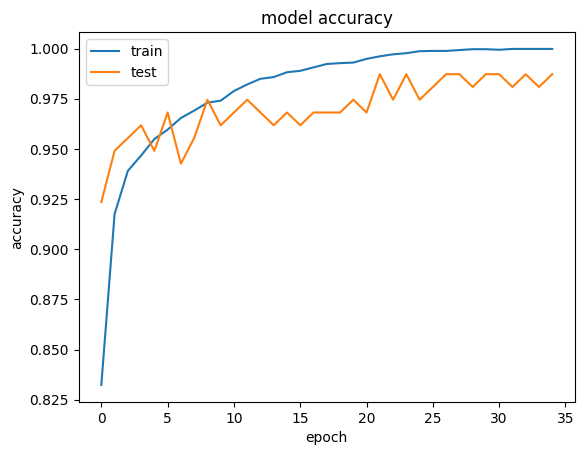

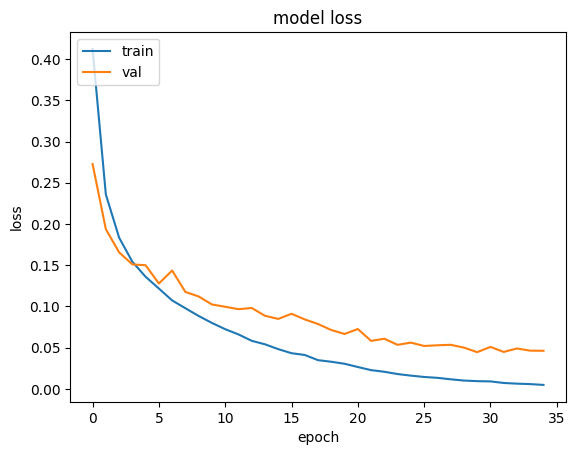

In [12]:
from matplotlib import pyplot  as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc ='upper left')
plt.show()
#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc ='upper left')
plt.show()

In [13]:
model.save('model1.h5')

In [14]:
model1 = load_model('/kaggle/working/model1.h5')

In [15]:

y_hat = model1.predict(X_test_scaled)
def predict(y_hat):
    y_hat[y_hat >= 0.5] =1
    y_hat[y_hat<0.5] =0
    return y_hat
y_pred = predict(y_hat)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
result= []
real_result = []
for i in y_pred:
    if i==0:
        result.append('Normal')
    if i==1:
        result.append('Covid')
for i in y_pred:
    if i==0:
        real_result.append('Normal')
    if i==1:
        real_result.append('Covid')

20/20 [==============================] - 3s 136ms/step
0.9761146496815286


In [16]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
labels = ['Covid', 'Normal']
report = classification_report(y_test, y_pred, target_names=labels)
print(report)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

              precision    recall  f1-score   support

       Covid       0.98      0.97      0.98       344
      Normal       0.97      0.98      0.97       284

    accuracy                           0.98       628
   macro avg       0.98      0.98      0.98       628
weighted avg       0.98      0.98      0.98       628

Accuracy: 0.9761146496815286


[[335   9]
 [  6 278]]


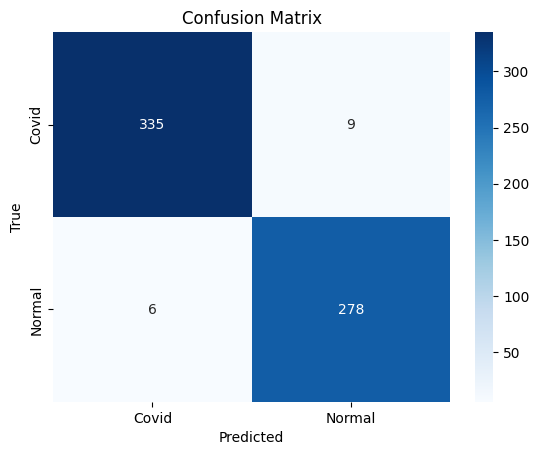

In [17]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Cấu hình trục x và trục y
tick_labels = ['Covid', 'Normal']
plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

# Đặt tên cho các trục
plt.xlabel('Predicted')
plt.ylabel('True')

# Hiển thị biểu đồ
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def show_image_with_prediction(image_array, prediction, label):
    plt.imshow(image_array)
    plt.axis('off')
    plt.title(f'Prediction: {prediction}, Label: {label}')
    plt.show()

image_arrays = X_test
predictions = result
label = real_result

# In ra ảnh từ mảng cùng với nhãn dự đoán cho từng ảnh
for image_array, prediction, label in zip(image_arrays, predictions, label):
    show_image_with_prediction(image_array/255, prediction, label)
    

In [36]:
name_list = glob.glob("/kaggle/input/covid19-data/Covid/COVID-19_Radiography_Dataset/Prediction_Input/*")

#Load the training images and labels
X_input= []
for name in name_list:
  img = cv2.imread(name)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = cv2.resize(img,(128,128)) 

  X_input.append((img))

In [37]:
X_input=np.array(X_input)
X_input = X_input/255
model1 = load_model('/kaggle/working/model1.h5')
y_hat = model1.predict(X_input)
y_pred = predict(y_hat)

1/1 [==============================] - 0s 155ms/step


In [38]:
result_pred =[]
for i in y_pred:
    if i==0:
        result_pred.append('Normal')
    if i==1:
        result_pred.append('Covid')

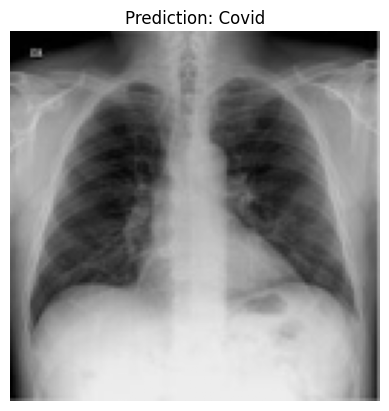

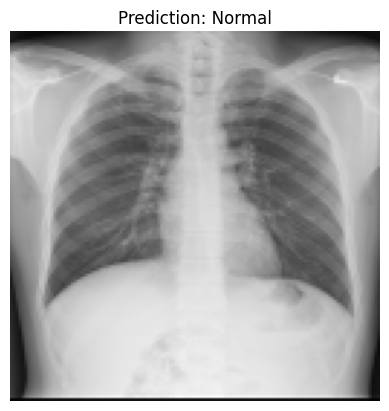

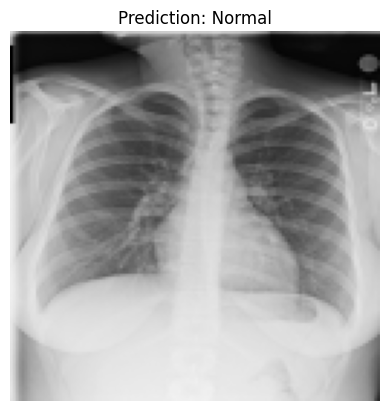

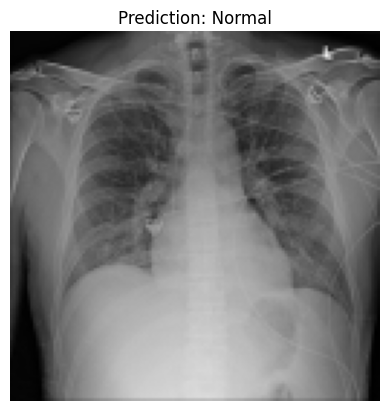

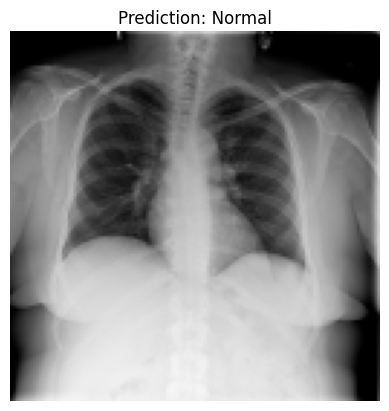

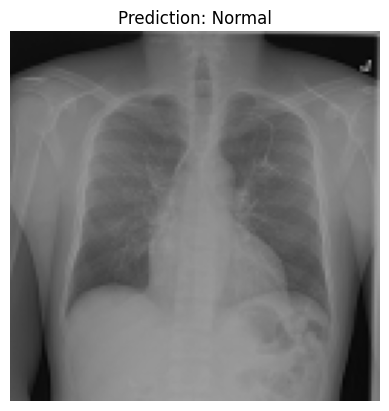

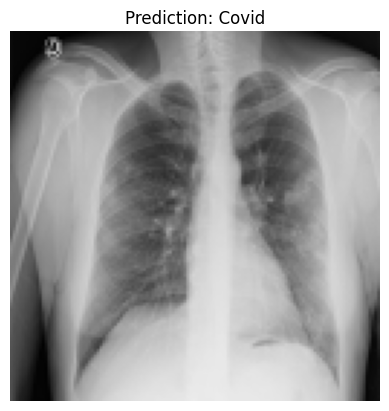

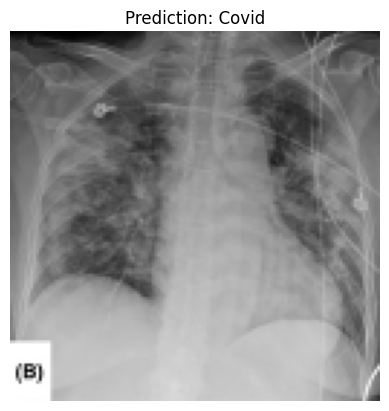

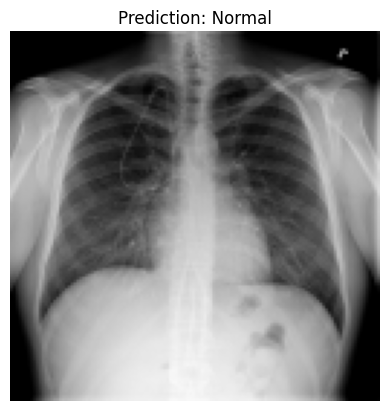

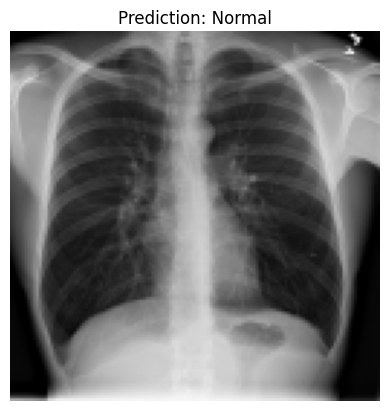

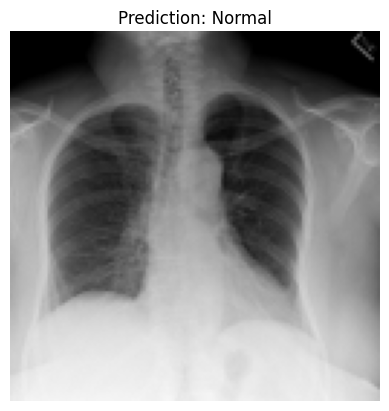

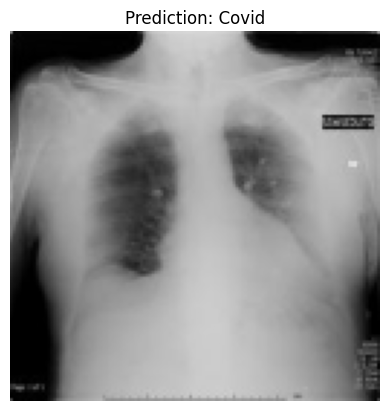

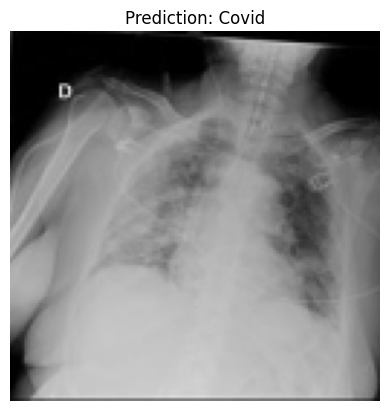

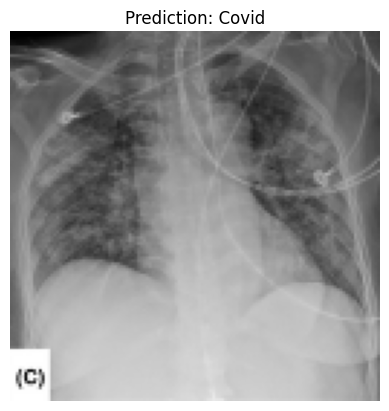

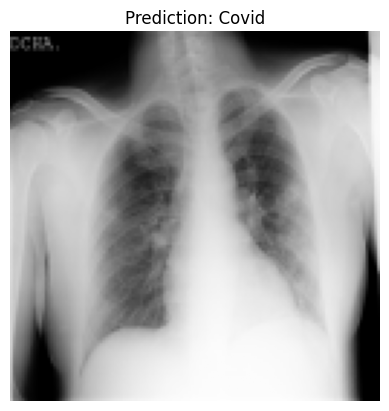

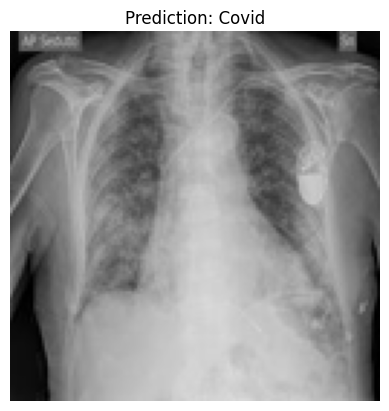

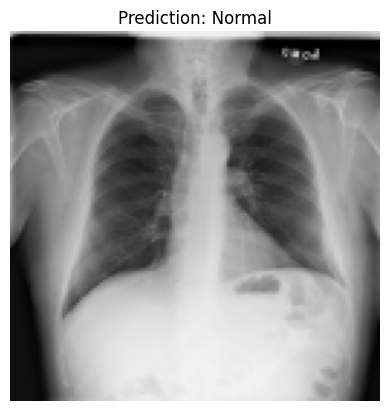

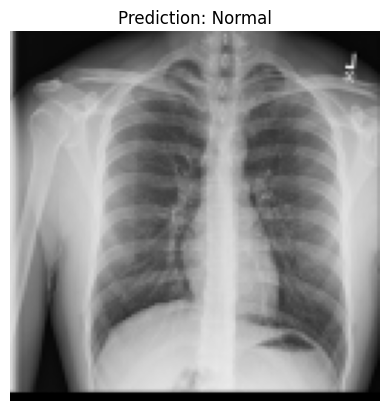

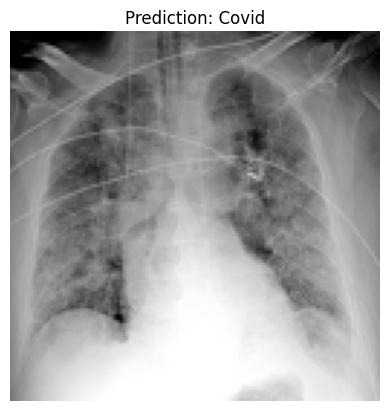

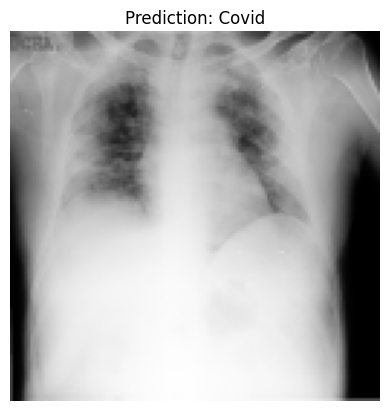

<Figure size 640x480 with 0 Axes>

In [39]:
import matplotlib.pyplot as plt
import os

def show_image_with_prediction(image_array, prediction):
    plt.imshow(image_array)
    plt.axis('off')
    plt.title(f'Prediction: {prediction}')
    plt.show()

image_arrays = X_input
predictions = result_pred
for image_array, prediction in zip(image_arrays, predictions):
    show_image_with_prediction(image_array, prediction)
output_dir = "/kaggle/working/images"  
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for i, (image_array, prediction) in enumerate(zip(image_arrays, predictions)):
    filename = f"image_{i}_prediction_{prediction}.jpg"
    file_path = os.path.join(output_dir, filename)
    plt.savefig(file_path)
